# Project 2: Ames Housing

We have completed the data cleaning and eda processes. Now we will create linear regression models and understand which models are best at predicting prices. After identifying the best model, we will implement the model using the test dataset and submit our predictions to kaggle.

## Data Preprocessing

In order to build the best models to predict our dependent variable, which is sale prices of properties, we have to ensure that all of our features can be processed by our regression models. Hence we will use one-hot encoding to handle the nominal data. 

Let us import all necessary libraries first, followed by our data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNet, ElasticNetCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor

%matplotlib inline

In [2]:
train_cleaned = pd.read_csv('./data/train_cleaned.csv')
test_cleaned = pd.read_csv('./data/test_cleaned.csv')

In [3]:
#for kaggle submission purposes
test = pd.read_csv('./data/test.csv')

In [4]:
train_cleaned.shape

(2048, 49)

In [5]:
test_cleaned.shape

(879, 48)

Fix errors that occurred during conversion.

In [6]:
train_cleaned[train_cleaned.columns[train_cleaned.isnull().any()]].isnull().sum().sort_values(ascending = False)

garage_type    114
dtype: int64

In [7]:
train_cleaned['garage_type'] = train_cleaned['garage_type'].astype(str)
train_cleaned['garage_type'].fillna(value = 'NA', inplace = True)

In [8]:
test_cleaned[test_cleaned.columns[test_cleaned.isnull().any()]].isnull().sum().sort_values(ascending = False)

garage_type    44
dtype: int64

In [9]:
test_cleaned['garage_type'].fillna(value = 'NA', inplace = True)

From Part 1, we have narrowed down our nominal, categorical and ordinal features as the following:

In [10]:
continuous_feat = ['lot_area', 'mas_vnr_area', 'bsmtfin_sf_1', 'bsmt_unf_sf', '1st_flr_sf', '2nd_flr_sf', 'gr_liv_area',
                   'garage_area', 'wood_deck_sf','year_remod_add','age']

In [11]:
ordinal_feat = ['lot_shape', 'overall_qual', 'overall_cond', 'exter_qual', 'exter_cond', 'bsmt_qual', 'bsmt_cond',
                'bsmt_exposure', 'bsmtfin_type_1', 'heating_qc', 'electrical', 'kitchen_qual', 'garage_finish', 'paved_drive',
                'bsmt_full_bath', 'bsmt_half_bath', 'full_bath', 'half_bath', 'bedroom_abvgr', 'fireplaces']

In [12]:
nominal_feat = ['ms_subclass', 'ms_zoning', 'land_contour', 'lot_config', 'neighborhood', 'bldg_type', 'house_style',
                'roof_style', 'exterior_1st', 'exterior_2nd', 'mas_vnr_type', 'foundation', 'sale_type', 'garage_type',
                'pool', 'mo_sold', 'porch']

### One Hot Encoding

#### Train Dataset

In [13]:
#create ohe object 
ohe = OneHotEncoder(handle_unknown='ignore') 

In [14]:
#we will perform one hot encoding on the nominal features for the train set first
train_nom = train_cleaned[nominal_feat]
train_nom_ohe = ohe.fit_transform(train_nom).toarray()

#convert to dataframe to join back to train_cleaned dataset
ohe_df = pd.DataFrame(train_nom_ohe, columns = ohe.get_feature_names())

#merge to train_cleansed
train_cleaned = train_cleaned.join(ohe_df).drop(columns = nominal_feat)

Then, we need to scale our dataset to avoid experiencing any problems during modelling. Scaling will be applied to our continuous and ordinal features.

In [15]:
#create standard scaler object
ss = StandardScaler()

In [16]:
#concat both continuous and nominal features
cols = continuous_feat + ordinal_feat

#transform data
train_scaled = train_cleaned[cols]
train_sc = ss.fit_transform(train_scaled)

#convert to dataframe to join back to train_cleaned dataset
sc_df = pd.DataFrame(train_sc, columns = cols)

#merge to train_cleaned
train_cleaned = train_cleaned.drop(columns = cols).join(sc_df)

#### Test Dataset

In [17]:
#we will perform one hot encoding on the nominal features for the train set first
test_nom = test_cleaned[nominal_feat]
test_nom_ohe = ohe.fit_transform(test_nom).toarray()

#convert to dataframe to join back to train_cleaned dataset
ohe_df = pd.DataFrame(test_nom_ohe, columns = ohe.get_feature_names())

#merge to train_cleansed
test_cleaned = test_cleaned.join(ohe_df).drop(columns = nominal_feat)

In [18]:
#transform data
test_scaled = test_cleaned[cols]
test_sc = ss.fit_transform(test_scaled)

#convert to dataframe to join back to train_cleaned dataset
sc_df = pd.DataFrame(test_sc, columns = cols)

#merge to train_cleaned
test_cleaned = test_cleaned.drop(columns = cols).join(sc_df)

### Train Test Split

The train_cleaned dataset is a hold-out dataset. Hence we will split this into training and testing before using our models on the test_cleaned dataset.

In [19]:
X = train_cleaned.drop(columns = 'saleprice')
y = train_cleaned['saleprice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=18)

### Modelling

#### All Features

##### Model 1 - Baseline Model

In [20]:
# Create a dummy regressor
dummy_mean = DummyRegressor(strategy='mean')

#cross validation
-(cross_val_score(dummy_mean, X_train, y_train, scoring='neg_root_mean_squared_error').mean())

79532.4756638837

In [21]:
# "Train" dummy regressor
dummy_mean.fit(X_train, y_train)

#conduct prediction using holdout test set
y_predict = dummy_mean.predict(X_test)
np.sqrt(mean_squared_error(y_predict, y_test))

78360.54346090519

##### Model 2 - Linear Regression

In [22]:
#create linear regression object
lr = LinearRegression()

In [23]:
#cross validation
-(cross_val_score(lr, X_train, y_train, scoring='neg_root_mean_squared_error').mean())

5226442899872870.0

In [24]:
#fit model
lr.fit(X_train, y_train)

LinearRegression()

In [25]:
#conduct prediction using holdout test set
y_predict = lr.predict(X_test)
np.sqrt(mean_squared_error(y_predict, y_test))

24896.490981654697

##### Model 3 - Ridge Regression

In [26]:
#find best alpha
#visualise alpha values on log scale
r_alphas = np.logspace(0, 5, 200)
ridge_model = RidgeCV(alphas = r_alphas, store_cv_values = True)
ridge_model.fit(X_train, y_train)

RidgeCV(alphas=array([1.00000000e+00, 1.05956018e+00, 1.12266777e+00, 1.18953407e+00,
       1.26038293e+00, 1.33545156e+00, 1.41499130e+00, 1.49926843e+00,
       1.58856513e+00, 1.68318035e+00, 1.78343088e+00, 1.88965234e+00,
       2.00220037e+00, 2.12145178e+00, 2.24780583e+00, 2.38168555e+00,
       2.52353917e+00, 2.67384162e+00, 2.83309610e+00, 3.00183581e+00,
       3.18062569e+00, 3.37006433e+0...
       2.64308149e+04, 2.80050389e+04, 2.96730241e+04, 3.14403547e+04,
       3.33129479e+04, 3.52970730e+04, 3.73993730e+04, 3.96268864e+04,
       4.19870708e+04, 4.44878283e+04, 4.71375313e+04, 4.99450512e+04,
       5.29197874e+04, 5.60716994e+04, 5.94113398e+04, 6.29498899e+04,
       6.66991966e+04, 7.06718127e+04, 7.48810386e+04, 7.93409667e+04,
       8.40665289e+04, 8.90735464e+04, 9.43787828e+04, 1.00000000e+05]),
        store_cv_values=True)

In [27]:
#optimal alpha
ridge_model.alpha_

6.010276782070384

In [28]:
best_ridge_model = Ridge(ridge_model.alpha_)

In [29]:
#cross validation
-(cross_val_score(best_ridge_model, X_train, y_train, scoring='neg_root_mean_squared_error').mean())

25109.908404416165

In [30]:
#conduct prediction using holdout test set

#fit model
best_ridge_model.fit(X_train, y_train)

y_predict = best_ridge_model.predict(X_test)
np.sqrt(mean_squared_error(y_predict, y_test))

24075.881059834144

##### Model 4 - Lasso Regression

In [31]:
#find best alpha

lasso_model = LassoCV(n_alphas = 100)
lasso_model.fit(X_train, y_train)

LassoCV()

In [32]:
#optimal alpha
lasso_model.alpha_

64.7064320342182

In [33]:
best_lasso_model = Lasso(lasso_model.alpha_)

In [34]:
#cross validation
-(cross_val_score(best_lasso_model, X_train, y_train, scoring='neg_root_mean_squared_error').mean())

25116.738241318213

In [35]:
#conduct prediction using holdout test set

#fit model
best_lasso_model.fit(X_train, y_train)

y_predict_lasso = best_lasso_model.predict(X_test)
np.sqrt(mean_squared_error(y_predict_lasso, y_test))

23690.023423514715

##### Model 5 -Elastic Net Regression

In [36]:
enet_alphas = np.arange(0.01, 1.0, 0.005)
enet_model = ElasticNetCV(n_alphas = 100, cv=5)
enet_model.fit(X_train, y_train)

ElasticNetCV(cv=5)

In [37]:
#optimal alpha
enet_model.alpha_

129.41286406843648

In [38]:
best_enet_model = ElasticNet(enet_model.alpha_)

In [39]:
#cross validation
-(cross_val_score(best_enet_model, X_train, y_train, scoring='neg_root_mean_squared_error').mean())

71861.29623642642

In [40]:
#conduct prediction using holdout test set

#fit model
best_enet_model.fit(X_train, y_train)

y_predict = best_enet_model.predict(X_test)
np.sqrt(mean_squared_error(y_predict, y_test))

71006.38935419475

Evaluation:


| Model      | Cross Val Score | RMSE |
| :----------- | :-----------: | :-----------: |
| Model 1 : Baseline Model    | 79532 | 78360       |
| Model 2 : Linear Regression    | 5.23e+15 | 24896       |
| Model 3 : Ridge Regression     | 25109       | 24075        |
| Model 4 : Lasso Regression    | 25116        | 23690        |
| Model 5 : ElasticNet Regression   | 71861        | 71006       |

We created models based on the train_cleaned dataset consisting of 183 columns. Inspite, some models performed generally well across the different regression models with Ridge Regression having the best RMSE as compared to the Baseline Model.

Model 2 however had a high cross validation score due to lack of regularisation. Models 3 and 4 performed better because they were regularised, reducing errors and avoiding overfitting. What is also surprising is that Model 5 performed really badly, almost similar to the baselines score.

Overall, despite some of the models performing well, these are actually not the best models for predicting values as they involve too many features. In reality, buyers may not look at all 183 features and instead be looking at the ones that are better predictor of sale prices, 

We will look at the performance of the features through the coefficients from the best model and pick our best features.

### Feature Selection

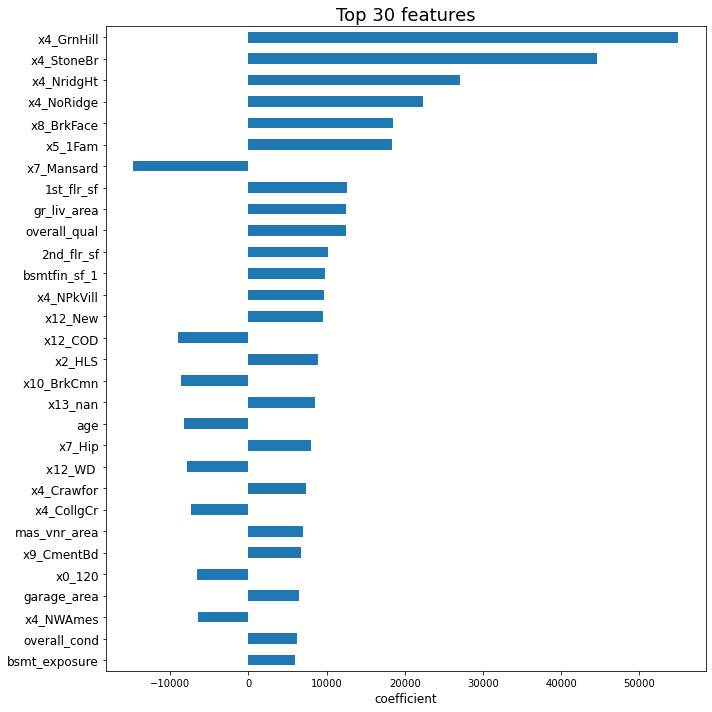

In [41]:
# get list of coefficients that are not 0
labels = [col for col in train_cleaned.columns if col != 'saleprice'] 
lasso_coef = pd.DataFrame(best_lasso_model.coef_, index = labels)            
lasso_coef = lasso_coef[lasso_coef[0] != 0]  #non-zero coefficients     

# sort by absolute values
lasso_coef = lasso_coef.reindex(lasso_coef[0].abs().sort_values(ascending=True).index)

#top 30 coefficients
lasso_coef.tail(30).plot.barh(figsize=(10,10), legend = None)
plt.title('Top 30 features',fontsize=18)
plt.xlabel('coefficient', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

From our correlation plot, it appears that the above ground living area is not the most influential feature in prediciting prices. In fact, neighboorhoods play a bigger role as well. The top 4 features represent the neighboorhoods that have huge influence on price. 

## Kaggle Submission

In [42]:
features = lasso_coef.tail(30).index.tolist()

In [43]:
features

['bsmt_exposure',
 'overall_cond',
 'x4_NWAmes',
 'garage_area',
 'x0_120',
 'x9_CmentBd',
 'mas_vnr_area',
 'x4_CollgCr',
 'x4_Crawfor',
 'x12_WD ',
 'x7_Hip',
 'age',
 'x13_nan',
 'x10_BrkCmn',
 'x2_HLS',
 'x12_COD',
 'x12_New',
 'x4_NPkVill',
 'bsmtfin_sf_1',
 '2nd_flr_sf',
 'overall_qual',
 'gr_liv_area',
 '1st_flr_sf',
 'x7_Mansard',
 'x5_1Fam',
 'x8_BrkFace',
 'x4_NoRidge',
 'x4_NridgHt',
 'x4_StoneBr',
 'x4_GrnHill']

In [44]:
# Retrain model again

features.remove('x4_GrnHill')
features.remove('x13_nan')

X_final = X[features]

lasso_model_final = LassoCV(n_alphas=100)
lasso_model_final.fit(X_final, y)


final_model = Lasso(alpha=lasso_model_final.alpha_)
final_model.fit(X_final, y)

# Creating predictions on test set
y_predit_final = final_model.predict(test_cleaned[features])

In [45]:
kaggle = pd.DataFrame({'Id': test.Id, 'Saleprice': y_predit_final})

In [46]:
kaggle.to_csv('./data/kaggle.csv')

[kagglesubmission.PNG](attachment:kaggle%20submission.PNG)

If image cannot be viewed, please see file under images.

Kaggle Score

Private: 31108

Public: 28724

### Conclusion and Recommendations

##### Conclusion

In [47]:
coef = pd.DataFrame([features, final_model.coef_]).T
coef.columns = ['Feature', 'Coefficient']

In [52]:
coef.sort_values(by = 'Coefficient', ascending = False)

,Feature,Coefficient
27,x4_StoneBr,46937
26,x4_NridgHt,38469.4
20,gr_liv_area,24133.2
23,x5_1Fam,21505
25,x4_NoRidge,20942.3
19,overall_qual,19357.5
24,x8_BrkFace,19239.6
15,x12_New,18064.9
8,x4_Crawfor,12843.3
17,bsmtfin_sf_1,11249.4


Based on our final model, it shows that neighborhoods such as Stone Brook and Northridge Heights have properties of high values. Single-family detached properties also have high coefficient value showcasing high property value. The overall quality of the property as well as the above ground living areas are important features in predicting prices of house as well.

On the other hand properties in Northwest Ames have lower sale prices. A property's age also affects the sale price of the property as well i.e. older the property, lower the sale.

##### Recommendations

1. Property dealers/buyers should consider properties in Stone Brook, Northridge Heights and Northridge Neighbourhoods for investment purposes as they yield higher sale prices. Will be more beneficial if property age is low as well. Also look into single-family detached properties/Hill side properties

2. Consider renovating to Brick Face exterior covering

3. Sell properties earlier as older properties yield lower sales

4. Avoid Masonry veneer types such as Brick Common.